# Correction : Classification Multi-classes de Chiffres Manuscrits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Partie 1 : Exploration et Préparation des Données

### 1.1 Chargement et exploration

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

unique, counts = np.unique(y, return_counts=True)
print("\nEchantillons par classe :")
for cls, cnt in zip(unique, counts):
    print(f"  Chiffre {cls} : {cnt}")


Echantillons par classe :
  Chiffre 0 : 178
  Chiffre 1 : 182
  Chiffre 2 : 177
  Chiffre 3 : 183
  Chiffre 4 : 181
  Chiffre 5 : 182
  Chiffre 6 : 181
  Chiffre 7 : 179
  Chiffre 8 : 174
  Chiffre 9 : 180


### 1.2 Visualisation des images

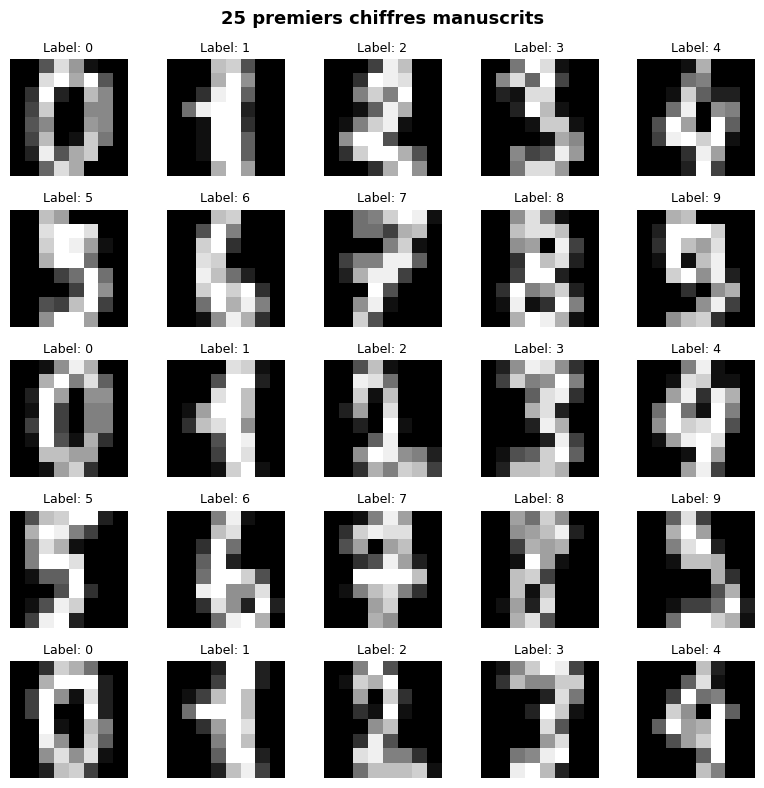

In [3]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}", fontsize=9)
    ax.axis('off')
plt.suptitle('25 premiers chiffres manuscrits', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 1.4 Préparation

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Partie 2 : Classification avec KNN

### 2.1 Premier modèle KNN

In [5]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree')) # pour utiliser tous les coeur du cpu
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      1.00      0.96        36
           2       0.95      1.00      0.97        35
           3       1.00      0.97      0.99        37
           4       0.97      0.94      0.96        36
           5       0.97      0.97      0.97        37
           6       0.97      1.00      0.99        36
           7       0.92      0.97      0.95        36
           8       0.97      0.89      0.93        35
           9       0.97      0.89      0.93        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



### 2.2 Optimisation de K

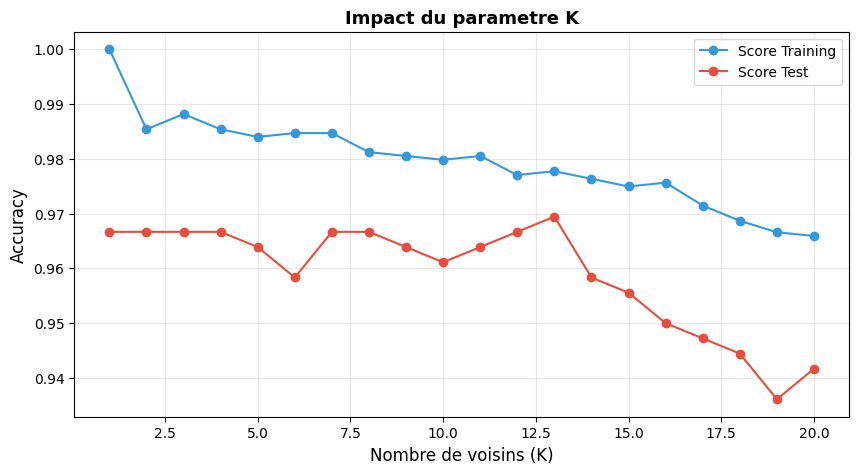

K optimal : 13


In [6]:
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', n_jobs=-1))
    ])
    pipe.fit(X_train, y_train)
    train_scores.append(pipe.score(X_train, y_train))
    test_scores.append(pipe.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(k_values, train_scores, label='Score Training', marker='o', color='#3498db')
plt.plot(k_values, test_scores, label='Score Test', marker='o', color='#e74c3c')
plt.xlabel('Nombre de voisins (K)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Impact du parametre K', fontweight='bold', fontsize=13)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_k = list(k_values)[np.argmax(test_scores)]
print(f"K optimal : {best_k}")

### 2.3 Analyse des erreurs - Matrice de confusion

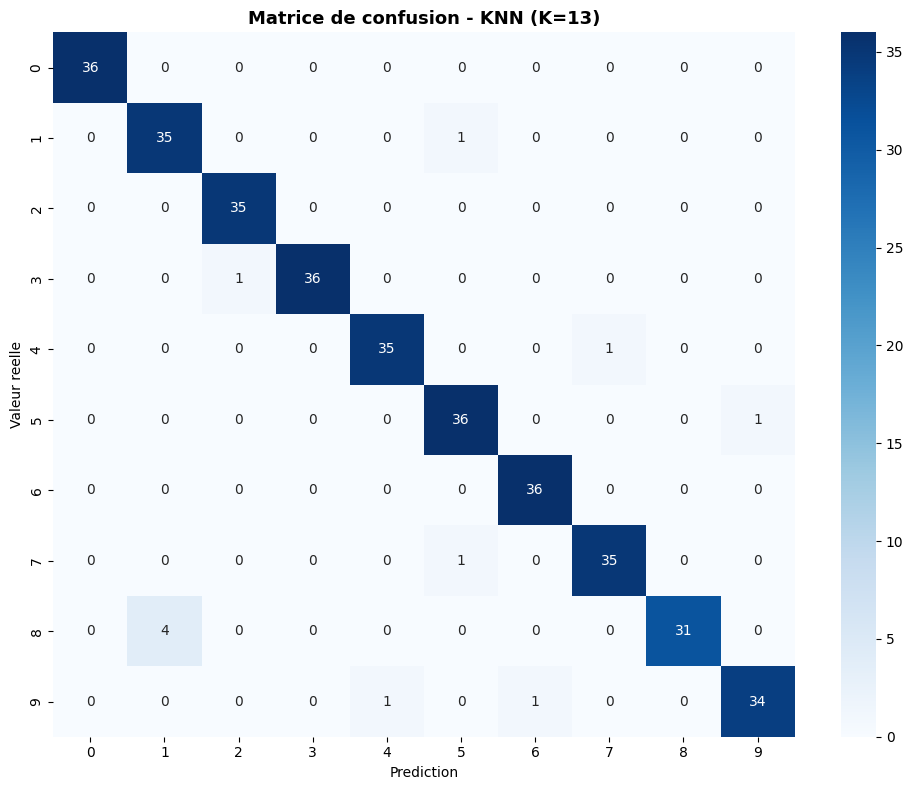

In [7]:
knn_best = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree', n_jobs=-1))
])
knn_best.fit(X_train, y_train)
y_pred_knn_best = knn_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred_knn_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title(f'Matrice de confusion - KNN (K={best_k})', fontsize=13, fontweight='bold')
plt.xlabel('Prediction')
plt.ylabel('Valeur reelle')
plt.tight_layout()
plt.show()

## Partie 3 : Classification avec Arbres de Décision

### 3.1 Arbre de base

In [8]:
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

train_acc = dt_pipeline.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree - Accuracy train : {train_acc:.3f}")
print(f"Decision Tree - Accuracy test  : {test_acc:.3f}")
print(f"Ecart train/test : {train_acc - test_acc:.3f} -> l'arbre overfitte")

Decision Tree - Accuracy train : 1.000
Decision Tree - Accuracy test  : 0.817
Ecart train/test : 0.183 -> l'arbre overfitte


### 3.2 Comparaison KNN vs Decision Tree

In [9]:
print(f"KNN (K={best_k})      : {max(test_scores):.3f}")
print(f"Decision Tree : {test_acc:.3f}")

KNN (K=13)      : 0.969
Decision Tree : 0.817


## Partie 4 : Méthodes d'Ensemble

### 4.1 Random Forest

In [10]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

t0 = time.time()
rf_pipeline.fit(X_train, y_train)
rf_time = time.time() - t0

y_pred_rf = rf_pipeline.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest (100 arbres) - Accuracy : {rf_acc:.3f} | Temps : {rf_time:.2f}s")

Random Forest (100 arbres) - Accuracy : 0.964 | Temps : 0.42s


### 4.2 Gradient Boosting

In [11]:
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

t0 = time.time()
gb_pipeline.fit(X_train, y_train)
gb_time = time.time() - t0

y_pred_gb = gb_pipeline.predict(X_test)
gb_acc = accuracy_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Accuracy : {gb_acc:.3f} | Temps : {gb_time:.2f}s")
print(f"Random Forest     - Accuracy : {rf_acc:.3f}")

Gradient Boosting - Accuracy : 0.953 | Temps : 9.17s
Random Forest     - Accuracy : 0.964


### 4.4 Voting Classifier

In [12]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree', n_jobs=-1)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

hard_voting = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', VotingClassifier(estimators=estimators, voting='hard'))
])

soft_voting = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', VotingClassifier(estimators=estimators, voting='soft'))
])

hard_voting.fit(X_train, y_train)
soft_voting.fit(X_train, y_train)

y_pred_hard = hard_voting.predict(X_test)
y_pred_soft = soft_voting.predict(X_test)

print(f"Hard Voting - Accuracy : {accuracy_score(y_test, y_pred_hard):.3f}")
print(f"Soft Voting - Accuracy : {accuracy_score(y_test, y_pred_soft):.3f}")

Hard Voting - Accuracy : 0.983
Soft Voting - Accuracy : 0.978


## Partie 5 : Pipeline Final

### 5.4 Rapport de performance

In [13]:

t0 = time.time()
knn_best.fit(X_train, y_train)
knn_time = time.time() - t0

t0 = time.time()
dt_pipeline.fit(X_train, y_train)
dt_time = time.time() - t0

t0 = time.time()
hard_voting.fit(X_train, y_train)
hard_time = time.time() - t0

t0 = time.time()
soft_voting.fit(X_train, y_train)
soft_time = time.time() - t0

models_eval = [
    ('KNN (K optimal)', knn_best, y_pred_knn_best, knn_time),
    ('Decision Tree', dt_pipeline, y_pred_dt, dt_time),
    ('Random Forest (100)', rf_pipeline, y_pred_rf, rf_time),
    ('Gradient Boosting', gb_pipeline, y_pred_gb, gb_time),
    ('Hard Voting', hard_voting, y_pred_hard, hard_time),
    ('Soft Voting', soft_voting, y_pred_soft, soft_time),
]

print(f"{'Modele':<25} {'Accuracy':>10} {'Temps':>10} {'Meilleur pour'}")
print("-" * 75)

comments = {
    'KNN (K optimal)': 'patterns locaux, simplicite',
    'Decision Tree': 'interpretabilite',
    'Random Forest (100)': 'robustesse, performance',
    'Gradient Boosting': 'haute precision',
    'Hard Voting': 'combinaison de modeles',
    'Soft Voting': 'meilleure combinaison',
}

results = []
for name, _, y_pred, t in models_eval:
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    print(f"{name:<25} {acc:>10.3f} {t:>8.2f}s {comments[name]}")

best_name = max(results, key=lambda x: x[1])[0]
print(f"\nMeilleur modele : {best_name} ({max(results, key=lambda x: x[1])[1]:.3f})")


Modele                      Accuracy      Temps Meilleur pour
---------------------------------------------------------------------------
KNN (K optimal)                0.969     0.02s patterns locaux, simplicite
Decision Tree                  0.817     0.03s interpretabilite
Random Forest (100)            0.964     0.42s robustesse, performance
Gradient Boosting              0.953     9.17s haute precision
Hard Voting                    0.983     9.31s combinaison de modeles
Soft Voting                    0.978     9.61s meilleure combinaison

Meilleur modele : Hard Voting (0.983)


### 5.2 Pipeline complet du meilleur modèle

In [14]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', VotingClassifier(
        estimators=[
            ('knn', KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree', n_jobs=-1)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
        ],
        voting='hard'
    ))
])

final_pipeline.fit(X_train, y_train)
final_acc = final_pipeline.score(X_test, y_test)
print(f"Pipeline final - Accuracy test : {final_acc:.3f}")

Pipeline final - Accuracy test : 0.983


### 5.6 Sauvegarde du modèle

In [15]:
joblib.dump(final_pipeline, 'best_digits_model.pkl')


['best_digits_model.pkl']